In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from tqdm import tqdm_notebook
from sklearn.base import BaseEstimator,TransformerMixin
import ppscore
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import ppscore

In [3]:
df = pd.read_csv('XYZCorp_LendingData.txt',sep='\t')

C:\Users\samal\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 73 columns):
id                             855969 non-null int64
member_id                      855969 non-null int64
loan_amnt                      855969 non-null float64
funded_amnt                    855969 non-null float64
funded_amnt_inv                855969 non-null float64
term                           855969 non-null object
int_rate                       855969 non-null float64
installment                    855969 non-null float64
grade                          855969 non-null object
sub_grade                      855969 non-null object
emp_title                      806526 non-null object
emp_length                     812908 non-null object
home_ownership                 855969 non-null object
annual_inc                     855969 non-null float64
verification_status            855969 non-null object
issue_d                        855969 non-null object
pymnt_plan           

# dividing train and test on basis of date

* train (june 2007-may 2015)
* test  (june 2015-dec 2015

In [5]:
test_df = df[(df['issue_d'] == 'Dec-2015') | (df['issue_d'] == 'Jun-2015') | (df['issue_d'] == 'Jul-2015') | (df['issue_d'] == 'Aug-2015') | (df['issue_d'] == 'Sep-2015') | (df['issue_d'] == 'Oct-2015') | (df['issue_d'] == 'Nov-2015') ]
train_df = df.drop(test_df.index,axis=0)

# Exporting train and test so we can use  the data directly

In [6]:
train_df.to_csv('train.csv',index_label=False)
test_df.to_csv('test.csv',index_label=False)

 * Deleting df and train_df,test_df and we again load data

In [7]:
del df,train_df,test_df

# Loading train data 
* we will first load train data and we will keep test data as unseen data
* we will make all preprocessing and predict finnaly on test data

In [18]:
train = pd.read_csv('train.csv')

C:\Users\samal\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598978 entries, 0 to 855968
Data columns (total 73 columns):
id                             598978 non-null int64
member_id                      598978 non-null int64
loan_amnt                      598978 non-null float64
funded_amnt                    598978 non-null float64
funded_amnt_inv                598978 non-null float64
term                           598978 non-null object
int_rate                       598978 non-null float64
installment                    598978 non-null float64
grade                          598978 non-null object
sub_grade                      598978 non-null object
emp_title                      564513 non-null object
emp_length                     570873 non-null object
home_ownership                 598978 non-null object
annual_inc                     598978 non-null float64
verification_status            598978 non-null object
issue_d                        598978 non-null object
pymnt_plan           

# from the anlysis made from info 

* there are lots of missing values 
* we need to removes cols that are higher percentage of missing values
* we will remove these missing columns
* since Higher the mising values these columns xcannot give more information
* Then we again anlyse the data about corelations and skewed data

In [ ]:
class Removing_NA_cols(BaseEstimator,TransformerMixin):
    """ This modeule is used to remove na colums
    you can gwuvw the limit as u like 
    null_th : null value in column threshold
          it is optional to give null threshold if not given default value
          50 will be taken
          
    how to use:
    
    model = Removing_NA_cols()
    model.fit(df)
    model.trnsform(df)
            or
    """
    def __init__(self,null_th = 50):
        self.null_th = null_th
        self.null_cols = []
    def fit(self,df):
        for col in tqdm_notebook(df.columns):
            if (sum(df[col].isna())/len(df))*100 > self.null_th:
                self.null_cols.append(col)
        return self
    def transform(self,df):
        df.drop(self.null_cols,axis=1,inplace=True)
        return self

# Making the above code as module would be great so that it can be reused

In [20]:
rna=Removing_NA_cols(null_th=50)

In [21]:
rna.fit_transform(train)

C:\Users\samal\anaconda3\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Removing_NA_cols(null_th=50)

#  Checking what are the null cols that are removed

In [23]:
rna.null_cols

['desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [24]:
train.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0


# NA cols are removed successfully
* Now we remove unecessary cols such as id ,member_id

In [177]:
train.drop(['id','member_id'],axis = 1,inplace=True)

* checkimg sample of data

In [25]:
pd.options.display.max_columns = None

In [26]:
train.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0


# Univariate analysis using pandas profiling

* there are various tools that we can use 
* But here we will use pandas profiling more cleaner anlysis
* panda profiling a very powerful tool for initial anlysis
* by using this we can see various interactions and corelations

In [96]:
report_train=train.profile_report(title="Pandas Profiling Report on train data",explorative=True,html={'style': {'full_width': True,'theme':'flatly'}},  interactions = {'targets' : ['default_ind']},progress_bar=True)

In [97]:
report_train.to_file(output_file='train_report.html')

# Analysis made using pandas profiling

# Data Overview

* There are total 51 variables in which 30 are numerical and 18 catogorical and three are bool
* data has 1.7% missing values

# Warnings in data

# High Cardinality

* these warnings such as Missing,cardinality,high corelation,high number of zeros etc
* policy code and application type are constant so they are of no use they can be removed
* There many features with high cardinality 
 * Issue_d(issue date)
 * title(title of loan application)
 * zip code(state zip code)
 * earliest_cr_line(when account was open for loan)
 * last_pymt_d(date when the last payment was made)
 * last_credit_pull_d(the last date when the lasst credit was pulled)

# Highly Corelated variables

* loan_amt,funded_amnt,funded_amnt_inv these columns have very high corelation since all them have same value ,so funded_amnt and funded_amnt_inv can be removed
* loan_amt and installment have corelation since installment will be deside based on loan_amnt
* out_prncp and out_prncp_inv have very high corelation so any of the one can be removed
* grade and subgarde have high corelation we can make some cahnges since they are categirical
* total_pymt ,total__pymt_inv,total_rec_prncp also very high corelation

# Column with missing values

* emp_title has 34465 (5.8%) missing values
* emp_length has 28105 (4.7%) missing values
* next_pymnt_d has 244687 (40.9%) missing values
* tot_coll_amt has 67313 (11.2%) missing values
* tot_cur_bal has 67313 (11.2%) missing values
* total_rev_hi_lim has 67313 (11.2%) missing values
* we need to find an imputation stratergy for missng value columns

# Highly skewed data

* annual_inc is highly skewed (γ1 = 32.59676251)
* collection_recovery_fee is highly skewed (γ1 = 23.99513225)
* collections_12_mths_ex_med is highly skewed (γ1 = 24.52184047)	
* acc_now_delinq is highly skewed (γ1 = 28.43505937)	
* tot_coll_amt is highly skewed (γ1 = 706.75678)	
* total_rev_hi_lim is highly skewed (γ1 = 81.5153322)
* we need investigate more on these columns

# Columns with high Zeros

* delinq_2yrs has 488733 (81.6%) zeros	
* inq_last_6mths has 324734 (54.2%) zeros	
* pub_rec has 513890 (85.8%) zeros	
* out_prncp has 244733 (40.9%) zeros	
* out_prncp_inv has 244733 (40.9%) zeros	
* total_rec_late_fee has 589426 (98.4%) zeros	
* recoveries has 574792 (96.0%) zeros	Zeros
* collection_recovery_fee has 575943 (96.2%) zeros	
* collections_12_mths_ex_med has 592719 (99.0%) zeros	
* acc_now_delinq has 596424 (99.6%) zeros	
* tot_coll_amt has 461105 (77.0%) zeros
* more anlysis hase to be made onthse columns

# Exploring Column with high cardinality

" emp_title 1 " |
" issue_d " |
" title " |
" zip_code " |
" earliest_cr_line " |
" last_pymnt_d " |
" last_credit_pull_d " |

# emp_title


* since the cardinality of column is so hight its difficult tp plot

In [12]:
emp_title_group = train.groupby('emp_title').sum()

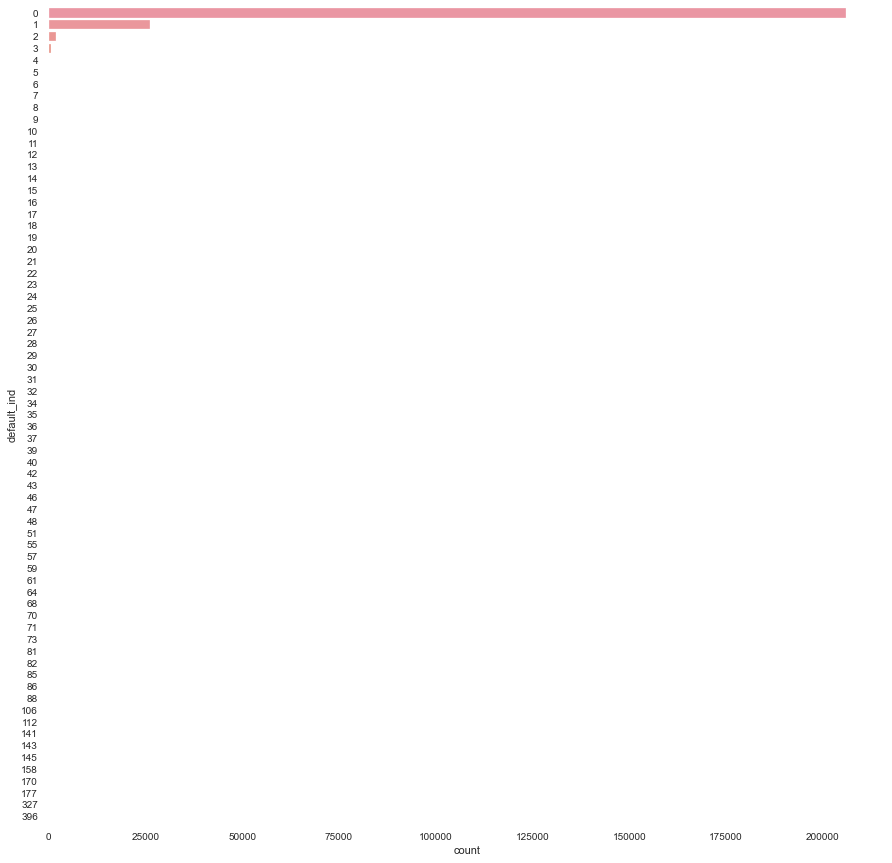

In [14]:
plt.figure(figsize=(15,15))
sns.countplot(y=emp_title_group['default_ind'])

* lets check some statistical evidence

# function for chi2 test to test significance

In [63]:
def chi2_independency_test(col1,col2):
    print('Null Hypothesis             : There is no Relationship')
    print('Alternate Hypothesis     : There is a Relationship')
    print('\n')
    df = pd.crosstab(col1,col2,margins=True,margins_name='tot')
    chi2_stat, p_val, dof, ex = chi2_contingency(df)
    print(f'chi2_stat                      :{chi2_stat}')
    print(f'pvalue                          :{p_val}')
    print(f'degress of freedom     : {dof}')
    print('\n')
    if p_val <  0.05 :
        print('===Null Hypotyhesis Rejected===')
        print('\n')
        print('===There is Relationship===')
    else:
        print('===Alternate Hypotyhesis Rejected===')
        print('\n')
        print('===There no is Relationship===')
    return chi2_stat,dof,p_val

In [59]:
result=chi2_independency_test(train['emp_title'],train['default_ind'])

Null Hypothesis             : There is no Relationship
Alternate Hypothesis     : There is a Relationship


chi2_stat                      :299014.9676696411
pvalue                          :1.0
degress of freedom     : 470624


===Alternate Hypotyhesis Rejected===


===There no is Relationship===


* As we can Clearly see that emp_title that does not have do any thing with this column soit can be removed

# Issue_d

* its cardinality is 93 lets plot

In [123]:
train['issue_d']     # checking sample

0         Dec-2011
1         Dec-2011
2         Dec-2011
3         Dec-2011
4         Dec-2011
            ...   
855964    Jan-2015
855965    Jan-2015
855966    Jan-2015
855967    Jan-2015
855968    Jan-2015
Name: issue_d, Length: 598978, dtype: object

In [74]:
result=chi2_independency_test(train['issue_d'],train['default_ind'])

Null Hypothesis             : There is no Relationship
Alternate Hypothesis     : There is a Relationship


chi2_stat                      :18329.158397489853
pvalue                          :0.0
degress of freedom     : 192


===Null Hypotyhesis Rejected===


===There is Relationship===


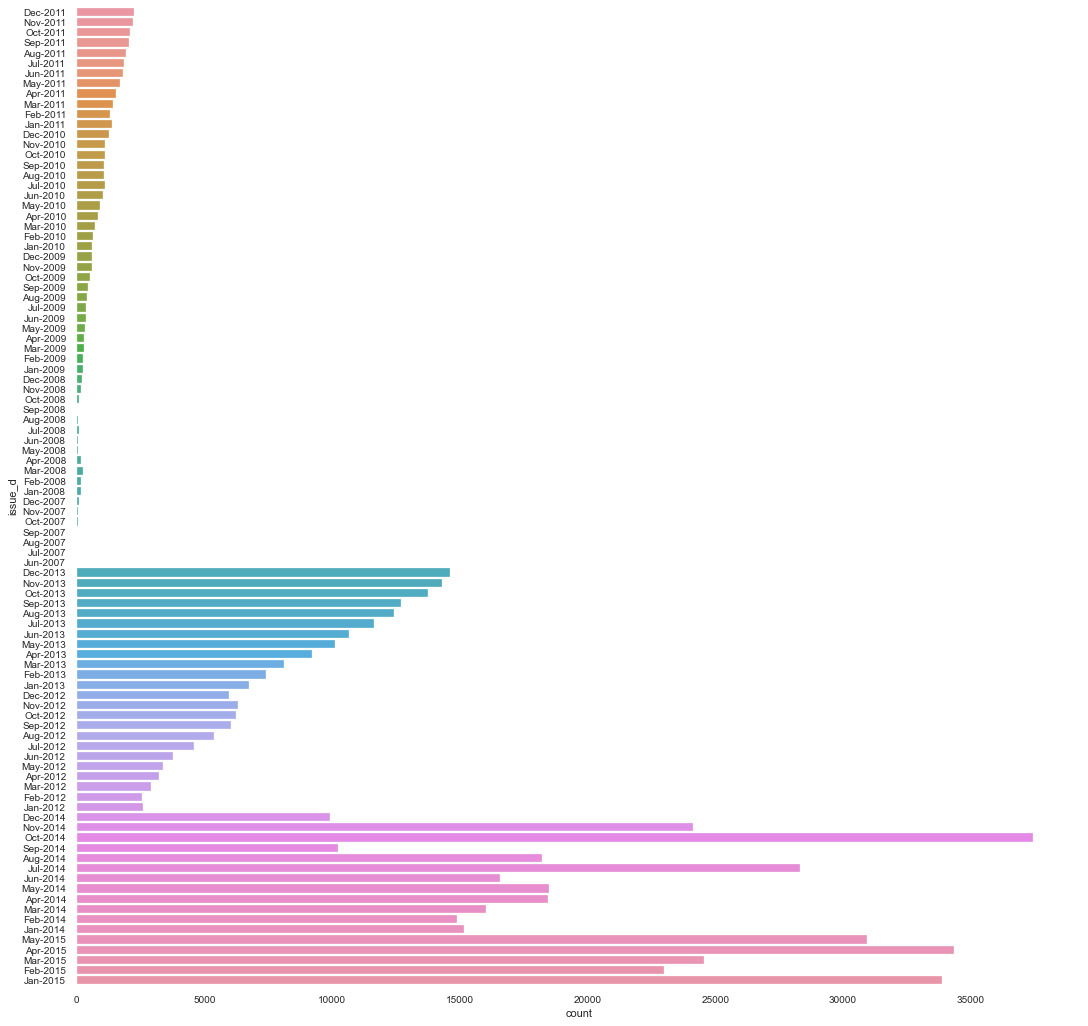

In [126]:
plt.figure(figsize=(18,18))
sns.countplot(y=train['issue_d'])

* as we can clearly see as the year increases number loans issued also increases
* lets make some changes to column like spliting month and year and check

In [42]:
issue_d_mnth   = [i.split(sep = '-')[0]  for i in tqdm_notebook(train['issue_d'])]
issue_d_year   = [i.split(sep = '-')[1]  for i in tqdm_notebook(train['issue_d'])]

C:\Users\samal\anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\Users\samal\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


* by using this method we can reduuce cardinality and it reduces to 21 columns from 93
* we can also efford this cardinality indata

In [43]:
train['issue_d_mnth'] = issue_d_mnth
train['issue_d_year'] = issue_d_year

In [64]:
result=chi2_independency_test(train['issue_d_year'],train['default_ind'])

Null Hypothesis             : There is no Relationship
Alternate Hypothesis     : There is a Relationship


chi2_stat                      :16549.943546858016
pvalue                          :0.0
degress of freedom     : 18


===Null Hypotyhesis Rejected===


===There is Relationship===


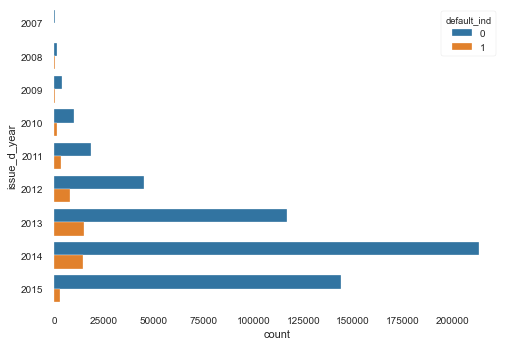

In [157]:
sns.countplot(y=train['issue_d_year'],hue=train['default_ind'])

* we can clearly see as the years increases no loans issues also increased
* defaults are are also getting inceraed but default rate is decreased
* lets check mean default value for  each year
* we can see this on year 11,12,13,14,15 years 
* we can conclude onthe evidence this moght be important 
* This column also has some cotrealtion to taget column 
* correalation(phik) can be seen in pandas profiling
* chi2 test also proves there is a relation

# title

In [168]:
train['title']     # checking sample
                    # since due to high cardinality it canoot be plotted individually

0                        Computer
1                            bike
2            real estate business
3                        personel
4                        Personal
                   ...           
855964         Debt consolidation
855965           Home improvement
855966         Debt consolidation
855967         Debt consolidation
855968    Credit card refinancing
Name: title, Length: 598978, dtype: object

In [170]:
train['title']=train['title'].str.lower() # removing case senstivity

In [171]:
title_group=train.groupby('title').sum()

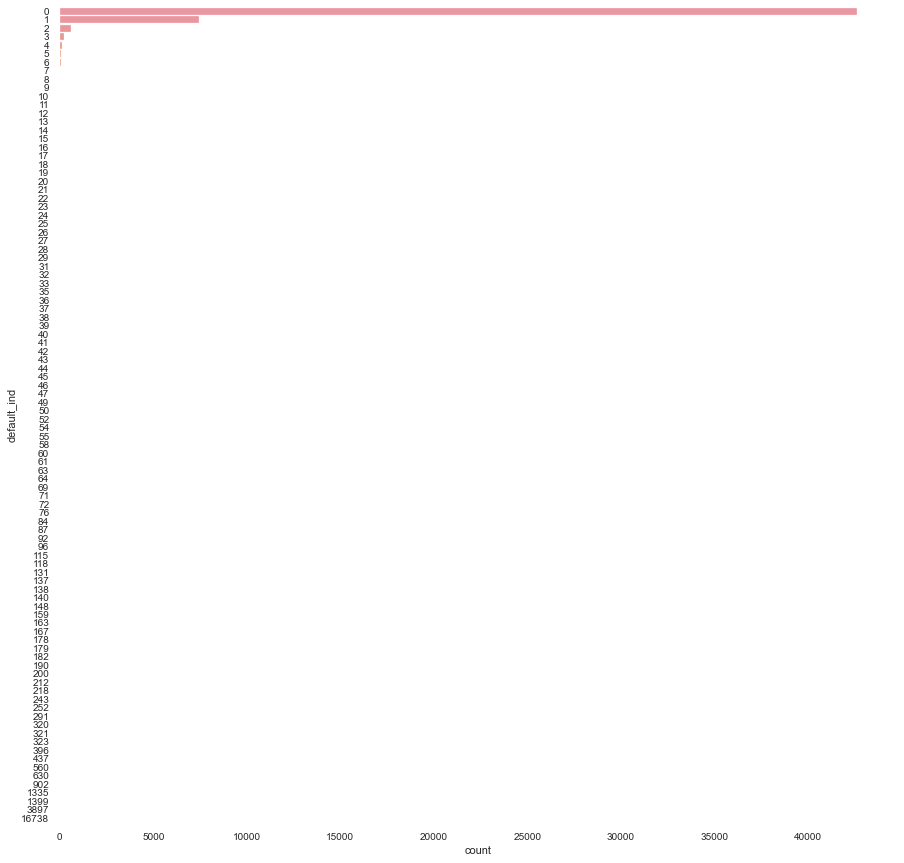

In [172]:
plt.figure(figsize=(15,15))
sns.countplot(y=title_group['default_ind'])

In [61]:
result=chi2_independency_test(train['title'],train['default_ind'])

Null Hypothesis             : There is no Relationship
Alternate Hypothesis     : There is a Relationship


chi2_stat                      :108168.80907676269
pvalue                          :1.0
degress of freedom     : 121980


===Alternate Hypotyhesis Rejected===


===There no is Relationship===


* we can clearly there is noralationship better to drop the column if there exist any lon linear relationship we cannot efford that cardinality in our data
* so best statery is to drop
* we can also go for catagorical embeding using nearural networks but its computainally so high
* ch2 test alsp shows that there is no reation

# zip code

In [176]:
train['zip_code']       # checking sample
                                # since due to high cardinality it canoot be plotted individually

0         860xx
1         309xx
2         606xx
3         917xx
4         972xx
          ...  
855964    905xx
855965    072xx
855966    378xx
855967    010xx
855968    331xx
Name: zip_code, Length: 598978, dtype: object

* this column is encode with 'xx' at the end so this column is mostly bot useful

 # earliest_cr_line

In [69]:
train['earliest_cr_line']     # checking sample
                                        # since due to high cardinality it canoot be plotted individually

0         Jan-1985
1         Apr-1999
2         Nov-2001
3         Feb-1996
4         Jan-1996
            ...   
855964    Sep-2004
855965    Mar-1974
855966    Sep-2003
855967    Oct-2003
855968    Dec-2001
Name: earliest_cr_line, Length: 598978, dtype: object

* lets divide and check

In [70]:
earliest_cr_line_mnth   = [i.split(sep = '-')[0]  for i in tqdm_notebook(train['earliest_cr_line'])]
earliest_cr_line_year   = [i.split(sep = '-')[1]  for i in tqdm_notebook(train['earliest_cr_line'])]

C:\Users\samal\anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\Users\samal\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [71]:
train['earliest_cr_line_mnth'] =earliest_cr_line_mnth
train['earliest_cr_line_year'] = earliest_cr_line_year

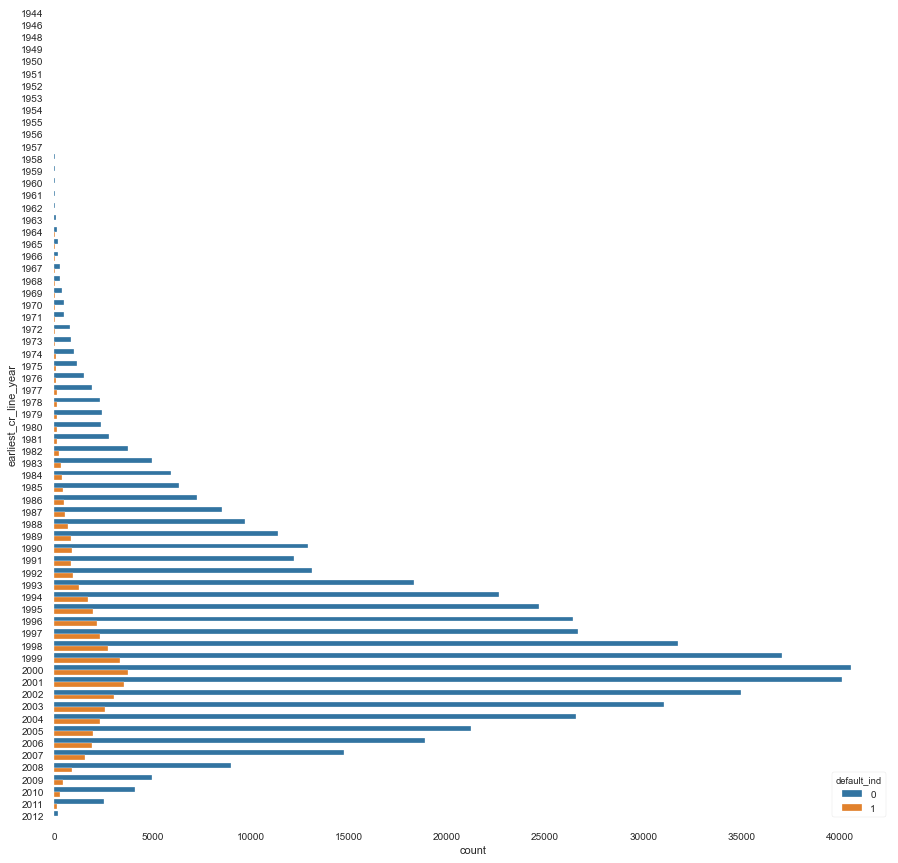

In [72]:
plt.figure(figsize=(15,15))
sns.countplot(y=train['earliest_cr_line_year'],hue=train['default_ind'])

In [73]:
result=chi2_independency_test(train['earliest_cr_line'],train['default_ind'])

Null Hypothesis             : There is no Relationship
Alternate Hypothesis     : There is a Relationship


chi2_stat                      :1444.8101398277868
pvalue                          :0.04269387133157035
degress of freedom     : 1354


===Null Hypotyhesis Rejected===


===There is Relationship===


* p_vlue of earliest cr line show there is an underling relation ship

# last_pymnt_d

In [75]:
train['last_pymnt_d']    # checking sample
                                    # since due to high cardinality it canoot be plotted individually

0         Jan-2015
1         Apr-2013
2         Jun-2014
3         Jan-2015
4         Jan-2016
            ...   
855964    Jan-2016
855965    Jan-2016
855966    Jan-2016
855967    Jan-2016
855968    Jan-2016
Name: last_pymnt_d, Length: 598978, dtype: object

* sinece it is similar to issue_d lets divide and check
* this column also has null values
* temprarily we fill na with constant value na

In [77]:
tr_cp = train.copy() # making a  copy fo this anlysis

In [78]:
tr_cp['last_pymnt_d'].fillna('na-na',inplace=True)

In [79]:
last_pymnt_d_mnth   = [i.split(sep = '-')[0]  for i in tqdm_notebook(tr_cp['last_pymnt_d'])]
last_pymnt_d_year   = [i.split(sep = '-')[1]  for i in tqdm_notebook(tr_cp['last_pymnt_d'])]

C:\Users\samal\anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\Users\samal\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [81]:
tr_cp['last_pymnt_d_mnth'] =last_pymnt_d_mnth
tr_cp['last_pymnt_d_year'] = last_pymnt_d_year

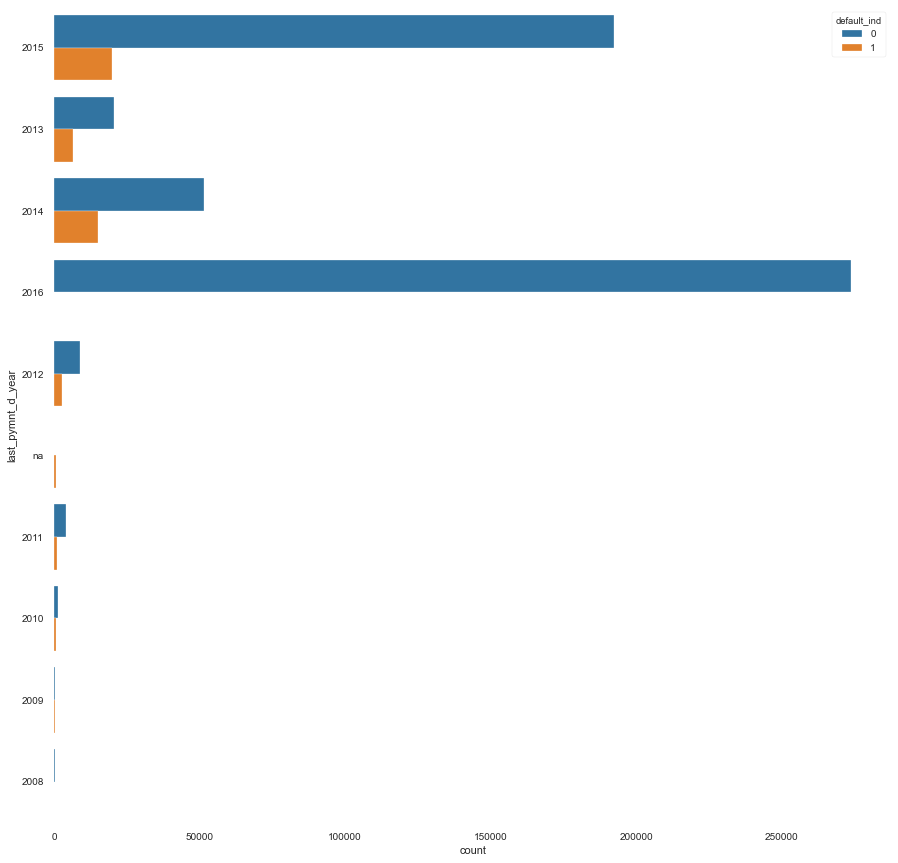

In [82]:
plt.figure(figsize=(15,15))
sns.countplot(y=tr_cp['last_pymnt_d_year'],hue=tr_cp['default_ind'])

In [83]:
result=chi2_independency_test(train['last_pymnt_d'],train['default_ind'])

Null Hypothesis             : There is no Relationship
Alternate Hypothesis     : There is a Relationship


chi2_stat                      :92200.34916909275
pvalue                          :0.0
degress of freedom     : 194


===Null Hypotyhesis Rejected===


===There is Relationship===


* there is some intesing pattern here we need keep it
* number of defauts are half equal to no defaults since we we defaultera are veru low 
* most of them are in 2015 and 2016
* since we are predicting for 2015 and after we need to keep this column
* we have also find that there some corelation here in data
* chi2 test also suggests that there is a reation ship

# last_credit_pull_d

In [84]:
train['last_pymnt_d']    # checking sample
                                    # since due to high cardinality it canoot be plotted individually

0         Jan-2015
1         Apr-2013
2         Jun-2014
3         Jan-2015
4         Jan-2016
            ...   
855964    Jan-2016
855965    Jan-2016
855966    Jan-2016
855967    Jan-2016
855968    Jan-2016
Name: last_pymnt_d, Length: 598978, dtype: object

* this column has missing values

In [85]:
tr_cp['last_credit_pull_d'].fillna('na-na',inplace=True) # imputing missing values

In [86]:
last_credit_pull_d_mnth   = [i.split(sep = '-')[0]  for i in tqdm_notebook(tr_cp['last_credit_pull_d'])]
last_credit_pull_d_year   = [i.split(sep = '-')[1]  for i in tqdm_notebook(tr_cp['last_credit_pull_d'])]

C:\Users\samal\anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\Users\samal\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [87]:
tr_cp['last_credit_pull_d_mnth'] =last_credit_pull_d_mnth
tr_cp['last_credit_pull_d_year'] = last_credit_pull_d_year

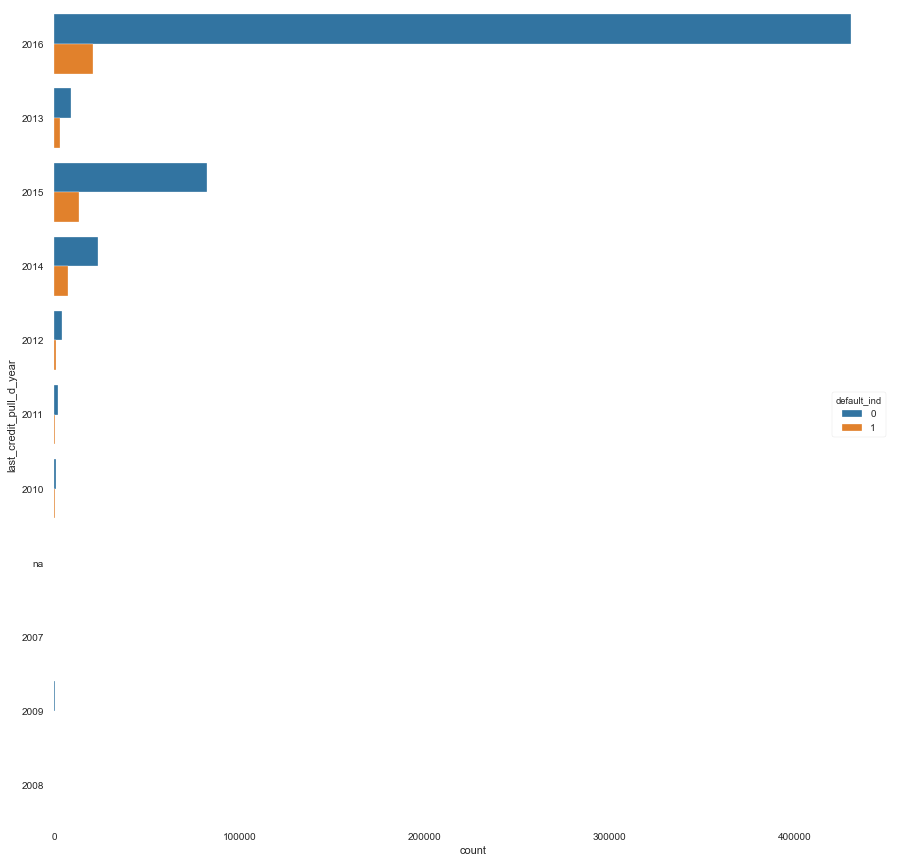

In [88]:
plt.figure(figsize=(15,15))
sns.countplot(y=tr_cp['last_credit_pull_d_year'],hue=tr_cp['default_ind'])

* sine every has equal number of defaluters are linearly growly it may not have much imprtance we need more investigation

In [89]:
result=chi2_independency_test(train['last_credit_pull_d'],train['default_ind'])

Null Hypothesis             : There is no Relationship
Alternate Hypothesis     : There is a Relationship


chi2_stat                      :37343.33680075882
pvalue                          :0.0
degress of freedom     : 204


===Null Hypotyhesis Rejected===


===There is Relationship===


In [156]:
result=chi2_independency_test(tr_cp['last_credit_pull_d_year'],tr_cp['default_ind'])

Null Hypothesis             : There is no Relationship
Alternate Hypothesis     : There is a Relationship


chi2_stat                      :29145.926679173732
pvalue                          :0.0
degress of freedom     : 22


===Null Hypotyhesis Rejected===


===There is Relationship===


* significant

# since this is a classification there is no need to deal with Multicollinearity

# so we ignore the warning

# As we see there missing columns in the data
# we need some stratergy to fill the missing value 

 * Filling missing values with universal constants such as " 0 " for numerical cols and "Nan" for catcols
 * Either filling with mean or median value to fill numerical columns and mode for categorical 
 * Use the advanced tecniques such as KNN or some advanced regression techniques to fill na
 * we address this in preprocessing

# Highly skewed data
annual_inc | 
collection_recovery_fee |
collections_12_mths_ex_med |
acc_now_delinq |
tot_coll_amt |
total_rev_hi_lim |

# annual_inc

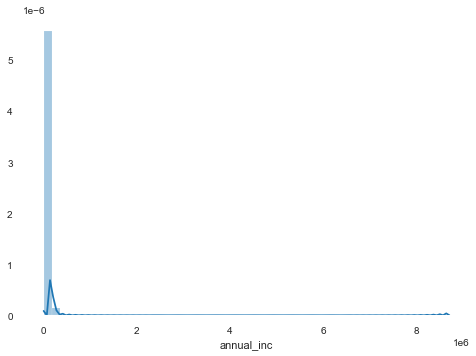

In [101]:
sns.distplot(train['annual_inc'])

In [125]:
ttest_ind(train['default_ind'],train['annual_inc'])

Ttest_indResult(statistic=-1008.6075386727232, pvalue=0.0)

* this statically tells that column is very imortant

# collection_recovery fee

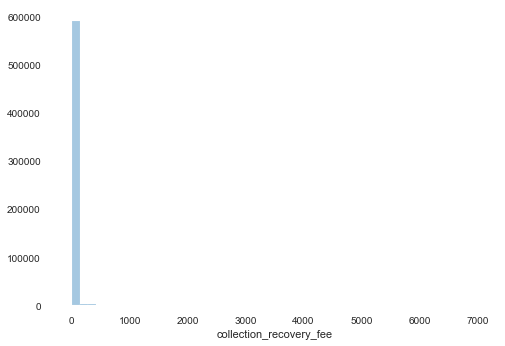

In [111]:
sns.distplot(train['collection_recovery_fee'],kde=False)

In [126]:
ttest_ind(train['default_ind'],train['collection_recovery_fee'])

Ttest_indResult(statistic=-72.61695992079586, pvalue=0.0)

* this column is statistically significant

# collections_12_mths_ex_med

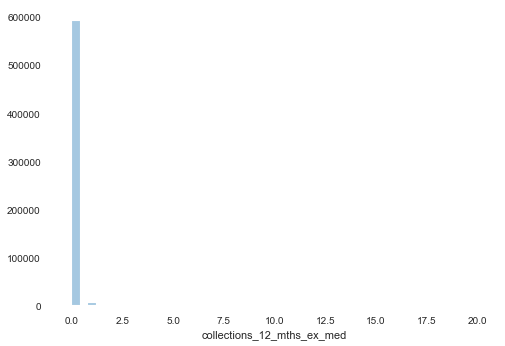

In [129]:
sns.distplot(train['collections_12_mths_ex_med'],kde=False)

In [132]:
ttest_ind(train['default_ind'],train['collections_12_mths_ex_med'])

Ttest_indResult(statistic=nan, pvalue=nan)

* this column might not be significant

# acc_now_delinq

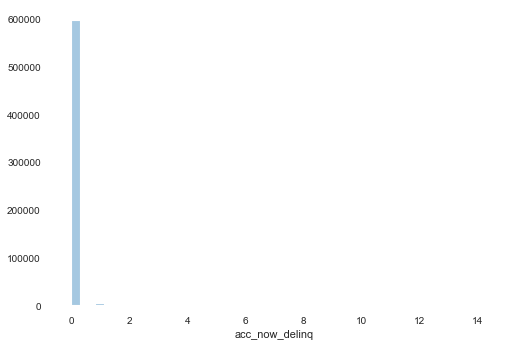

In [135]:
sns.distplot(train['acc_now_delinq'],kde=False)

In [136]:
ttest_ind(train['default_ind'],train['acc_now_delinq'])

Ttest_indResult(statistic=202.16836183495954, pvalue=0.0)

* might be significant

# tot coll amnt

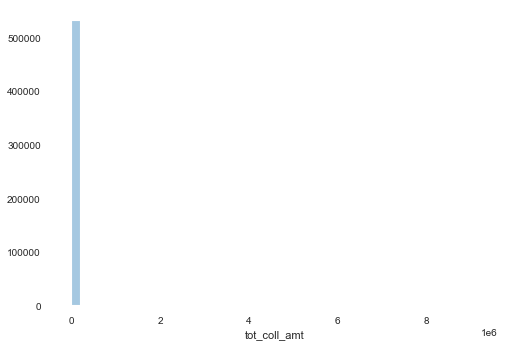

In [137]:
sns.distplot(train['tot_coll_amt'],kde=False)

In [155]:
ttest_ind(train['default_ind'],train['tot_coll_amt'])

C:\Users\samal\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\Users\samal\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\Users\samal\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



Ttest_indResult(statistic=nan, pvalue=nan)

* might not be significant

# total rev hi lim

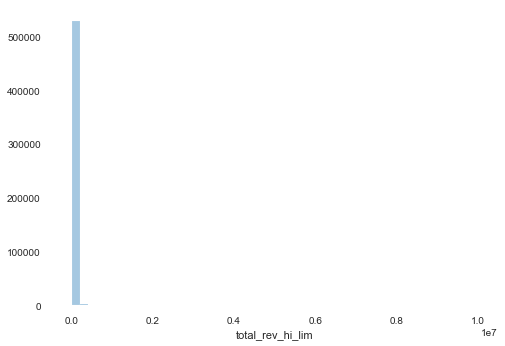

In [142]:
sns.distplot(train['total_rev_hi_lim'],kde=False)

In [150]:
ttest_ind(train['default_ind'],train['total_rev_hi_lim'])

C:\Users\samal\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\Users\samal\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\Users\samal\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



nan

* might not be significant

# Columns with high Zeros
delinq_2yrs | 
inq_last_6mths | 
pub_rec |
out_prncp |
out_prncp_inv |
total_rec_late_fee |
recoveries |
collection_recovery_fee |
collections_12_mths_ex_med |
acc_now_delinq | 
tot_coll_amt 

In [147]:
sub=train[['delinq_2yrs','inq_last_6mths','pub_rec','out_prncp','out_prncp_inv','total_rec_late_fee','recoveries', 'collection_recovery_fee' ,'collections_12_mths_ex_med','acc_now_delinq' , 'tot_coll_amt']]

In [151]:
def annova_test(sub):
    statistic = [ttest_ind(train['default_ind'],train[col])[0]  for col in sub.columns]
    p_value = [ttest_ind(train['default_ind'],train[col])[1]  for col in sub.columns]
    df = pd.DataFrame()
    df['columns'] = [col for col in sub.columns]
    df['statistic'] = statistic
    df['p_value'] = p_value
    return df

In [153]:
df=annova_test(sub)

C:\Users\samal\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\Users\samal\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\Users\samal\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



In [158]:
df

,columns,statistic,p_value
0,delinq_2yrs,-195.693138,0.0
1,inq_last_6mths,-488.961613,0.0
2,pub_rec,-128.018015,0.0
3,out_prncp,-627.872265,0.0
4,out_prncp_inv,-627.836552,0.0
5,total_rec_late_fee,-65.950028,0.0
6,recoveries,-105.809285,0.0
7,collection_recovery_fee,-72.616960,0.0
8,collections_12_mths_ex_med,NaN,NaN
9,acc_now_delinq,202.168362,0.0


# columns that can be removed based on statistical evidence

 ['emp_title','title','zip_code','collections_12_mths_ex_med','total_rev_hi_lim','tot_coll_amnt','policy_code','application_type']

In [5]:
train.drop(['emp_title','title','zip_code','collections_12_mths_ex_med','total_rev_hi_lim','tot_coll_amt'],axis=1,inplace=True)

In [27]:
train.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,n,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.00,0.00,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,Dec-2011,n,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3,12.0,f,0.00,0.00,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-2015,161.03,NaN,Sep-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
6,1069639,1304742,7000.0,7000.0,7000.0,60 months,15.96,170.08,C,C5,Southern Star Photography,8 years,RENT,47004.0,Not Verified,Dec-2011,n,debt_consolidation,Loan,280xx,NC,23.51,0.0,Jul-2005,1.0,7.0,0.0,17726.0,85.6,11.0,f,1889.15,1889.15,8136.840000,8136.84,5110.85,3025.99,0.00,0.00,0.00,Jan-2016,170.08,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
7,1072053,1288686,3000.0,3000.0,3000.0,36 months,18.64,109.43,E,E1,MKC Accounting,9 years,RENT,48000.0,Source Verified,Dec-2011,n,car,Car Downpayment,900xx,CA,5.35,0.0,Jan-2007,2.0,4.0,0.0,8221.0,87.5,4.0,f,0.00,0.00,3938.144334,3938.14,3000.00,938.14,0.00,0.00,0.00,Jan-2015,111.34,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
8,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,n,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,2.0,11.0,0.0,5210.0,32.6,13.0,f,0.00,0.00,646.020000,646.02,162.02,294.94,0.00,189.06,2.09,Apr-2012,152.39,NaN,Aug-2012,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
9,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,Starbucks,< 1 year,RENT,15000.0,Verified,Dec-2011,n,other,Building my credit history.,774xx,TX,18.08,0.0,Sep-2004,0.0,2.0,0.0,9279.0,36.5,3.0,f,0.00,0.00,1476.190000,1469.34,673.48,533.42,0.00,269.29,2.5

In [29]:
drop_cols = ['emp_title','title','zip_code','collections_12_mths_ex_med','total_rev_hi_lim','tot_coll_amt']